# Target Ensemble

Apart from the main target, there are actually many auxilliary targets in the dataset. 

These targets are fundamentally related to the main target which make them potentially helpful in modelling the main target. And because these targets have low correlation with one another, it means that we can use them to build a diverse set of models that should ensemble quite nicely. 

In this notebook, we will 
1. Explore the auxilliary targets
2. Use cross-validation to select our favorite targets
3. Create a simple ensemble of models trained on our favorite targets

In [1]:
# Install dependencies
!pip install -q numerapi pandas matplotlib lightgbm pyarrow cloudpickle

# Inline plots
%matplotlib inline

## 1. Auxilliary Targets

Let's start by taking a look at the targets in the training data.

In [2]:
import pandas as pd
import json
from numerapi import NumerAPI

# Download data
napi = NumerAPI()
napi.download_dataset("v4.1/train.parquet");
napi.download_dataset("v4.1/features.json");

# Load data
feature_metadata = json.load(open("v4.1/features.json")) 
feature_cols = feature_metadata["feature_sets"]["small"]
target_cols = feature_metadata["targets"]
training_data = pd.read_parquet("v4.1/train.parquet", columns=["era"] + feature_cols + target_cols)

# Print target columns
pd.set_option('display.max_rows', 10)
pd.set_option('display.max_columns', 10)
training_data[["era"] + target_cols]

2023-08-02 21:18:24,778 INFO numerapi.utils: target file already exists
2023-08-02 21:18:24,779 INFO numerapi.utils: download complete
2023-08-02 21:18:25,263 INFO numerapi.utils: target file already exists
2023-08-02 21:18:25,264 INFO numerapi.utils: download complete


,era,target,target_nomi_v4_20,target_nomi_v4_60,target_tyler_v4_20,...,target_caroline_v4_60,target_sam_v4_20,target_sam_v4_60,target_xerxes_v4_20,target_xerxes_v4_60
id,,,,,,,,,,,
n003bba8a98662e4,0001,0.25,0.25,0.00,0.50,...,0.25,0.25,0.25,0.25,0.25
n003bee128c2fcfc,0001,0.75,0.75,0.75,0.75,...,0.75,0.75,0.75,0.75,0.75
n0048ac83aff7194,0001,0.25,0.50,0.25,0.50,...,0.25,0.50,0.25,0.25,0.25
n00691bec80d3e02,0001,0.75,0.75,0.50,0.50,...,0.50,0.75,0.50,0.75,0.50
n00b8720a2fdc4f2,0001,0.50,0.75,0.50,0.75,...,0.50,0.50,0.50,0.50,0.50
...,...,...,...,...,...,...,...,...,...,...,...
nffcc1dbdf2212e6,0574,0.75,0.75,1.00,0.75,...,1.00,0.75,1.00,0.75,1.00
nffd71b7f6a128df,0574,0.25,0.00,0.50,0.25,...,0.50,0.00,0.25,0.00,0.50
nffde3b371d67394,0574,0.25,0.25,0.50,0.50,...,0.75,0.25,0.75,0.50,0.75


First thing to note is that `target` is just an alias for `target_cyrus_v4_20`, so we can drop this column for the rest of the notebook.

In [3]:
# Drop `target` column
assert training_data["target"].equals(training_data["target_cyrus_v4_20"])
target_names = target_cols[1:]
targets_df = training_data[["era"] + target_names]

At a high level, each target represents a different kind of stock market return
- the `name` represents the type of stock market return (eg. residual to market/country/sector or market/country/style)
- the `_20` or `_60` suffix denotes the time horizon of the target (ie. 20 or 60 market days)

In [4]:
# Print target names grouped by name and time horizon
pd.set_option('display.max_rows', 100)
t20s = [t for t in target_names if t.endswith("_20")]
t60s = [t for t in target_names if t.endswith("_60")]
names = [t[7:-6] for t in t20s]
pd.DataFrame({"name": names,"20": t20s,"60": t60s}).set_index("name")

,20,60
name,,
nomi,target_nomi_v4_20,target_nomi_v4_60
tyler,target_tyler_v4_20,target_tyler_v4_60
victor,target_victor_v4_20,target_victor_v4_60
ralph,target_ralph_v4_20,target_ralph_v4_60
waldo,target_waldo_v4_20,target_waldo_v4_60
jerome,target_jerome_v4_20,target_jerome_v4_60
janet,target_janet_v4_20,target_janet_v4_60
ben,target_ben_v4_20,target_ben_v4_60
alan,target_alan_v4_20,target_alan_v4_60


Note that some targets are binned into 5 bins while others are binned into 7 bins.

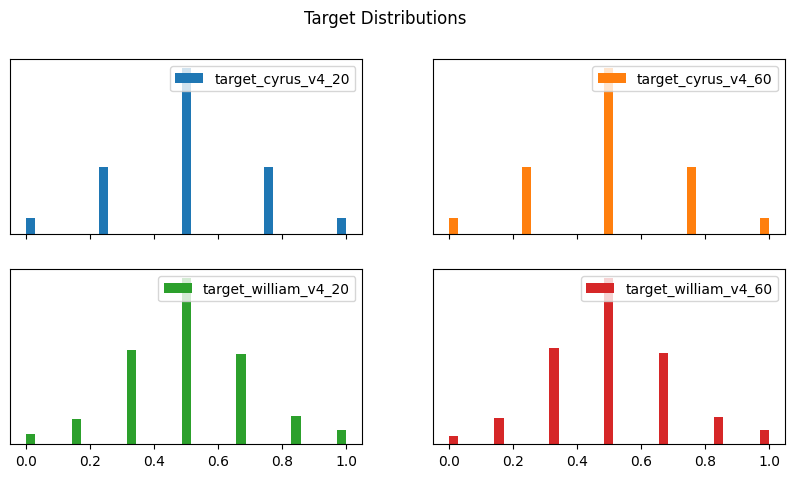

In [5]:
# Plot target distributions no y axis
targets_df[["target_cyrus_v4_20", "target_cyrus_v4_60", "target_william_v4_20", "target_william_v4_60"]].plot(kind="hist", bins=35, density=True, figsize=(10, 5), title="Target Distributions", subplots=True, layout=(2, 2), ylabel="", yticks=[]);

It is also important to note that the auxilary targets can be `NaN`, but the primary target will never be `NaN`.

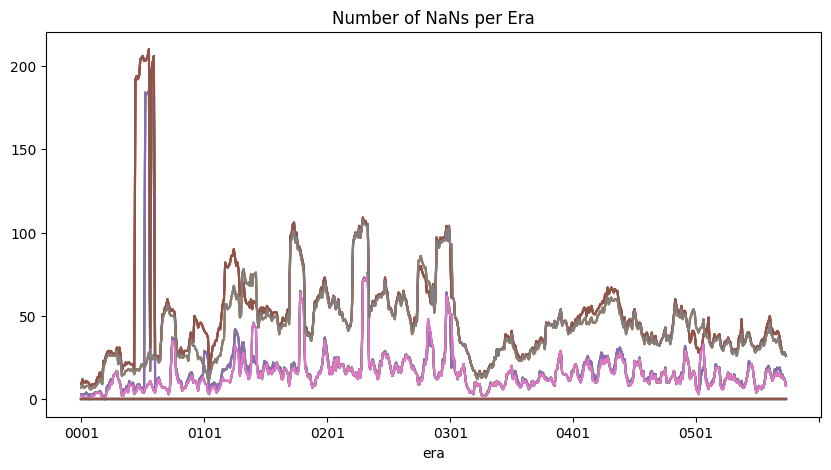

In [6]:
# print number of NaNs per era
nans_per_era = targets_df.groupby("era").apply(lambda x: x.isna().sum())
nans_per_era[target_names].plot(figsize=(10, 5), title="Number of NaNs per Era", legend=False);

The targets have a wide range of correlations with each other even though they are all fundamentally related, which should allow the construction of diverse models that ensemble together nicely.

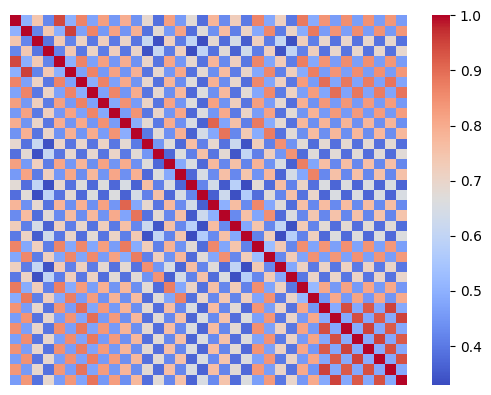

In [7]:
# Plot correlation matrix of targets
import seaborn as sns
sns.heatmap(targets_df[target_names].corr(), cmap="coolwarm", xticklabels=False, yticklabels=False);

## 2. Target Selection

Our goal is to create an ensemble of models trained on different targets. But which targets should we train on? 

To keep things simple, let's only consider the 20-day target variants. 

We will use cross validation to pick top our 3 favorite auxilliary targets based on best mean, sharpe, and max_drawdown. 

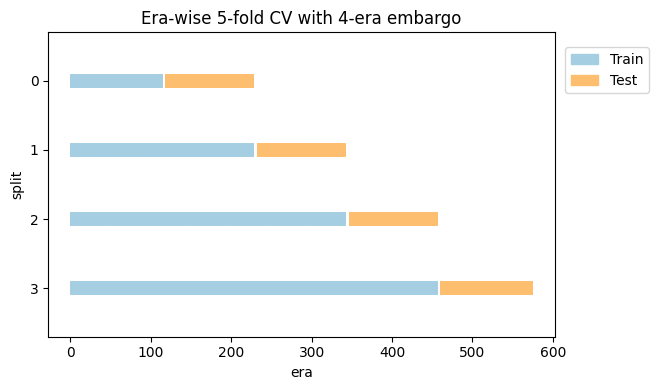

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
cmap_cv = plt.cm.Paired

def get_era_wise_cv_splits(eras, n_folds=5, embargo=0):
    # divide the eras into n_folds, adding any remainder eras to the last fold  
    len_fold = len(eras) // n_folds
    folds = [eras[i * len_fold : (i + 1) * len_fold] for i in range(n_folds)]
    folds[-1] = np.append(folds[-1], eras[n_folds * len_fold :])
    # create splits
    splits = []
    for train_fold_idx in range(n_folds-1):
        # train up to the current fold ("walk-forward")
        train = np.concatenate(folds[:train_fold_idx+1])
        # test in the next fold, but "embargo" some eras to prevent leakage
        test = folds[train_fold_idx+1][embargo:]
        splits.append((train, test))
    return splits

def plot_cv_splits(eras, cv_splits, title):
    fig, ax = plt.subplots()
    # add a bar for each split where nan=unused, 0=train, 1=test
    for ii, (tr, tt) in enumerate(cv_splits):
        df = pd.DataFrame(index=eras)
        df.loc[df.index.isin(tr), "group"] = 0
        df.loc[df.index.isin(tt), "group"] = 1
        ax.scatter(x=eras.astype(int), y=[ii + 0.5] * len(eras), c=df["group"].values, marker="_", s=1, lw=10, cmap=cmap_cv, vmin=0, vmax=2)
    # formatting
    fig.set_size_inches(8, 4)
    n_splits = len(cv_splits)
    ax.set(yticks=np.arange(n_splits) + 0.5, yticklabels=list(range(n_splits)), xlabel="era", ylabel="split", ylim=[n_splits + 0.2, -0.2])
    ax.set_title(title)
    ax.legend([Patch(color=cmap_cv(0)), Patch(color=cmap_cv(0.5))], ["Train", "Test"], loc=(1.02, 0.8))
    plt.tight_layout()
    fig.subplots_adjust(right=0.7)

cv_splits = get_era_wise_cv_splits(training_data["era"].unique(), n_folds=5, embargo=4)
plot_cv_splits(training_data["era"].unique(), cv_splits, "Era-wise 5-fold CV with 4-era embargo");

The chart above visualizes our cross validation plan
- We have split the training data into 5 folds and will be using folds 2, 3, 4, 5 (in orange) as our test splits
- We only train on eras before the test split to avoid leaking information from the future to the past (walk forward)
- We also "embargo" eras between each train and test split to prevent data leakage from train to test. We need to embargo 4 eras since we are using a 20-day target and each era in the trianing data is 5 days apart 

Using the CV splits above, we can create out-of-sample predictions on the training data to help us pick our favorite targets.

In [9]:
import lightgbm as lgb

# for each 20 day target...
for target in t20s:
    try: 
        # load the predictions if they exist...
        training_data[f"prediction_{target}"] = pd.read_parquet(f"prediction_{target}.parquet");
        print(f"loaded predictions for {target}")
    except:
        # otherwise, generate predictions using CV
        print(f"generating predictions for {target}")
        for ii, (train_eras, test_eras) in enumerate(cv_splits):
            print(f"split {ii}")
            model = lgb.LGBMRegressor(
                n_estimators=2000,
                learning_rate=0.01,
                max_depth=5,
                num_leaves=2 ** 5,
                colsample_bytree=0.1
            );
            # train on the training split
            train_split = training_data[training_data.era.isin(train_eras)];
            model.fit(
                train_split[feature_cols],
                train_split[target]
            );
            # predict on the test split
            test_split = training_data[training_data.era.isin(test_eras)];
            test_predictions = model.predict(test_split[feature_cols]);
            # splice the predictions back into the training data
            training_data.loc[test_split.index, f"prediction_{target}"] = test_predictions
        # save the predictions
        print(f"writing predictions for {target}")
        training_data[f"prediction_{target}"].to_frame().to_parquet(f"prediction_{target}.parquet")

loaded predictions for target_nomi_v4_20
loaded predictions for target_tyler_v4_20
loaded predictions for target_victor_v4_20
loaded predictions for target_ralph_v4_20
loaded predictions for target_waldo_v4_20
loaded predictions for target_jerome_v4_20
loaded predictions for target_janet_v4_20
loaded predictions for target_ben_v4_20
loaded predictions for target_alan_v4_20
loaded predictions for target_paul_v4_20
loaded predictions for target_george_v4_20
loaded predictions for target_william_v4_20
loaded predictions for target_arthur_v4_20
loaded predictions for target_thomas_v4_20
loaded predictions for target_cyrus_v4_20
loaded predictions for target_caroline_v4_20
loaded predictions for target_sam_v4_20
loaded predictions for target_xerxes_v4_20


Now that we have our out-of-sample predictions on the test set, let's evaluate them and generate some performance metrics.

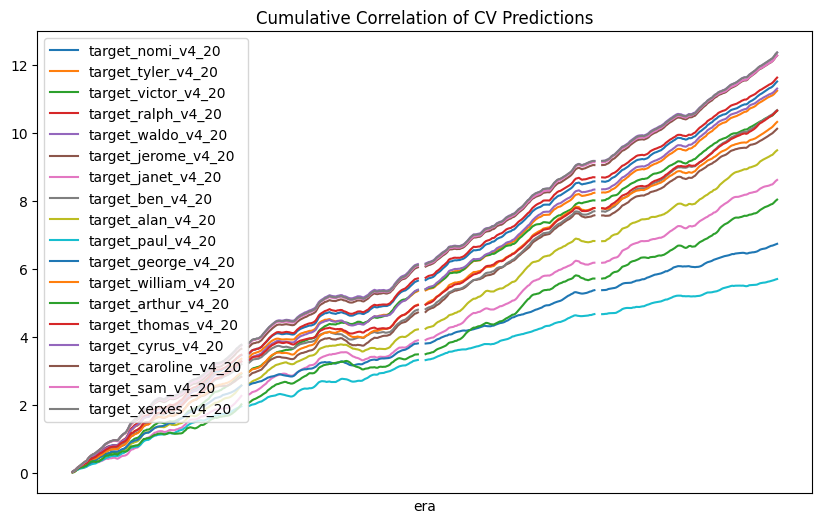

In [10]:
from scipy import stats
import numpy as np

# Numerai's primary scoring metric
def numerai_corr(preds, target):
    # rank (keeping ties) then gaussianize predictions to standardize prediction distributions
    ranked_preds = (preds.rank(method="average").values - 0.5) / preds.count()
    gauss_ranked_preds = stats.norm.ppf(ranked_preds)
    # center targets around 0
    centered_target = target - target.mean()
    # raise both preds and target to the power of 1.5 to accentuate the tails
    preds_p15 = np.sign(gauss_ranked_preds) * np.abs(gauss_ranked_preds) ** 1.5
    target_p15 = np.sign(centered_target) * np.abs(centered_target) ** 1.5
    # finally return the Pearson correlation
    return np.corrcoef(preds_p15, target_p15)[0, 1]

correlations = {}
cumulative_correlations = {}
for target in t20s:
    correlations[target] = training_data.groupby("era").apply(lambda d: numerai_corr(d[f"prediction_{target}"], d["target"]))
    cumulative_correlations[target] = correlations[target].cumsum() 

cumulative_correlations = pd.DataFrame(cumulative_correlations)
cumulative_correlations.plot(title="Cumulative Correlation of CV Predictions", figsize=(10, 6), xticks=[]);

Note the 4 sections with small gaps between them in the performance chart below. The 4 sections correspond to the 4 test splits and the gaps represent the eras embargo eras.

In [11]:
summary_metrics = {}
for col in t20s:
    mean = correlations[col].mean()
    std = correlations[col].std()
    sharpe = mean / std
    rolling_max = cumulative_correlations[col].expanding(min_periods=1).max()
    max_drawdown = (rolling_max - cumulative_correlations[col]).max()
    summary_metrics[col] = {
        "mean": mean,
        "std": std,
        "sharpe": sharpe,
        "max_drawdown": max_drawdown,
    }
pd.set_option('display.float_format', lambda x: '%f' % x)
cv_summary = pd.DataFrame(summary_metrics).T
cv_summary

,mean,std,sharpe,max_drawdown
target_nomi_v4_20,0.025906,0.019405,1.334981,0.104049
target_tyler_v4_20,0.025292,0.019153,1.320495,0.172474
target_victor_v4_20,0.023965,0.017782,1.347748,0.068073
target_ralph_v4_20,0.026165,0.019927,1.313019,0.137305
target_waldo_v4_20,0.025437,0.019507,1.304008,0.165225
target_jerome_v4_20,0.022774,0.019345,1.177289,0.223404
target_janet_v4_20,0.019385,0.018768,1.032914,0.237861
target_ben_v4_20,0.024009,0.018893,1.270786,0.225338
target_alan_v4_20,0.021348,0.019238,1.109676,0.210791
target_paul_v4_20,0.012820,0.012021,1.066429,0.085188


Now let's pick our 3 favorite auxilliary targets based on best mean, sharpe, and max_drawdown. We will also include the primary target `target_cryus_v4_20` since this is the main target.

Note that this is a very simplistic method of selecting targets. In your research, you may want to experiment with different ways of selecting targets for your ensemble.

In [12]:
# select the top 3 targets with the highest mean cv score 
best_mean = cv_summary.sort_values(by='mean', ascending=False).head(1).index
best_sharpe = cv_summary.sort_values(by='sharpe', ascending=False).head(1).index
best_max_drawdown = cv_summary.sort_values(by='max_drawdown', ascending=True).head(1).index
favorite_targets = ["target_cyrus_v4_20", best_mean[0], best_sharpe[0], best_max_drawdown[0]]
favorite_targets

['target_cyrus_v4_20',
 'target_xerxes_v4_20',
 'target_caroline_v4_20',
 'target_victor_v4_20']

## 3. Ensembling

Now let's train models on our favorite targets and evaluate the validation performance of our ensemble.

In [13]:
import lightgbm as lgb

def load_or_train_model(target: str):
    filename = f"small_lgb_{target}.model"
    try: 
        model = lgb.Booster(model_file=filename);
        print(f"loaded model for {target}")
    except lgb.basic.LightGBMError:
        print(f"training model for {target}")
        model = lgb.LGBMRegressor(
            n_estimators=2000,
            learning_rate=0.01,
            max_depth=5,
            num_leaves=2 ** 5,
            colsample_bytree=0.1
        )
        model.fit(
            training_data[feature_cols],
            training_data[target]
        );
        model.booster_.save_model(filename);
    return model

# Load or train models for each target to generate validation predictions
favorite_models = {}
for target in favorite_targets:
    favorite_models[target] = load_or_train_model(target)

loaded model for target_cyrus_v4_20
loaded model for target_xerxes_v4_20
loaded model for target_caroline_v4_20
loaded model for target_victor_v4_20


In [14]:
# Download validation data 
napi.download_dataset("v4.1/validation.parquet");

# Load the validation data but only the "small" subset of features
validation_data = pd.read_parquet("v4.1/validation.parquet", columns=["era", "data_type"] + feature_cols + target_cols) 

# Filter for data_type == "validation"
validation_data = validation_data[validation_data["data_type"] == "validation"]
del validation_data["data_type"]

2023-08-02 21:19:41,416 INFO numerapi.utils: target file already exists
2023-08-02 21:19:41,417 INFO numerapi.utils: download complete


For simplicity, we will just equal-weight our predictions. 

Note that this is an extremely basic and arbitrary way of selecting ensemble weights. In your research, you may want to experiment with different ways of setting ensemble weights.

Tip: remember to always normalize (percentile rank) your predictions before averaging so that they are comparable!

In [15]:
for target, model in favorite_models.items():
    validation_data[f"prediction_{target}"] = model.predict(validation_data[feature_cols])

# Ensemble predictions together with a simple average
pred_cols = [f"prediction_{target}" for target in favorite_targets]
validation_data["ensemble"] = validation_data.groupby("era")[pred_cols].rank(pct=True).mean(axis=1)
pred_cols += ["ensemble"]

Looking at the performance chart below, we can see that our ensemble has simlar but slightly better performance than the model trained just on `target_cyrus_v4_20`. This is pretty interesting given the individual models themselves all seem to perform slightly worse.

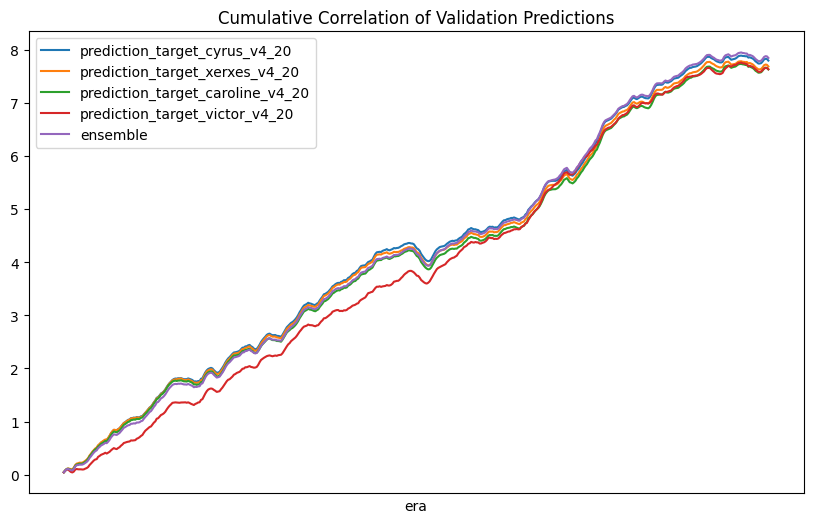

In [16]:
correlations = {}
cumulative_correlations = {}
for col in pred_cols:
    correlations[col] = validation_data.groupby("era").apply(lambda d: numerai_corr(d[col], d["target"]))
    cumulative_correlations[col] = correlations[col].cumsum() 

cumulative_correlations = pd.DataFrame(cumulative_correlations)
cumulative_correlations.plot(title="Cumulative Correlation of Validation Predictions", figsize=(10, 6), xticks=[]);

Looking at the summary metrics below, we can see that our ensemble seems to have better `mean`, `sharpe`, and `max_drawdown` than the default cyrus model which is great! 

In [17]:
summary_metrics = {}
for col in pred_cols:
    mean = correlations[col].mean()
    std = correlations[col].std()
    sharpe = mean / std
    rolling_max = cumulative_correlations[col].expanding(min_periods=1).max()
    max_drawdown = (rolling_max - cumulative_correlations[col]).max()
    summary_metrics[col] = {
        "mean": mean,
        "std": std,
        "sharpe": sharpe,
        "max_drawdown": max_drawdown,
    }
pd.set_option('display.float_format', lambda x: '%f' % x)
summary = pd.DataFrame(summary_metrics).T
summary

,mean,std,sharpe,max_drawdown
prediction_target_cyrus_v4_20,0.015776,0.021437,0.735907,0.342537
prediction_target_xerxes_v4_20,0.015553,0.021620,0.719396,0.343580
prediction_target_caroline_v4_20,0.015440,0.021314,0.724382,0.358087
prediction_target_victor_v4_20,0.015446,0.018895,0.817447,0.239126
ensemble,0.015877,0.020987,0.756551,0.327423


Based on these results, it seems like ensembling models trained on different auxiliary targets can potentially help with all aspects of performance. 

However, it is also important to note that whether or not to create an ensemble is completely up to you. In fact, there are many great performing models that don't make use of the auxilliary targets at all.

If you are interested in learning more about targets, we highly encourage you to read up on these forum posts
- https://forum.numer.ai/t/how-to-ensemble-models/4034
- https://forum.numer.ai/t/target-jerome-is-dominating-and-thats-weird/6513

To wrap up this notebook, let's pickle and upload our ensemble.

In [18]:
def predict_ensemble(live_features: pd.DataFrame) -> pd.DataFrame:
    # generate predictions from each model
    predictions = pd.DataFrame(index=live_features.index)
    for target, model in favorite_models.items():
        predictions[target] = model.predict(live_features[feature_cols])
    # ensemble predictions
    ensemble = predictions.rank(pct=True).mean(axis=1)
    # format submission
    submission = ensemble.rank(pct=True, method="first")
    return submission.to_frame("prediction")

In [19]:
# Quick test
current_round_number = napi.get_current_round()
napi.download_dataset("v4.1/live.parquet", f"v4.1/live_{current_round_number}.parquet")
live_features = pd.read_parquet(f"v4.1/live_{current_round_number}.parquet", columns=feature_cols)
predict_ensemble(live_features)

2023-08-02 21:28:18,215 INFO numerapi.utils: target file already exists
2023-08-02 21:28:18,216 INFO numerapi.utils: download complete


,prediction
id,
n000da261c544058,0.440178
n00152ec1d0be17a,0.472514
n001df3e95de9cdb,0.232215
n001e335c6bfbbbc,0.357518
n00295ce9df3a28c,0.807397
...,...
nffa230f45b0b5e4,0.686742
nffd34b6bb239369,0.806386
nffe45fc2b536694,0.232821


In [20]:
# Use the cloudpickle library to serialize your function and its dependencies
import cloudpickle
p = cloudpickle.dumps(predict_ensemble)
with open("predict_ensemble.pkl", "wb") as f:
    f.write(p)

In [21]:
# Download file if running in Google Colab
try:
    from google.colab import files
    files.download('predict_ensemble.pkl')
except:
    pass

That's it! Now head back to [numer.ai](numer.ai) to upload your model!